In [1]:
import numpy as np
import tensorflow as tf
import numpy as np
from collections import Counter

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
def sample_jester_data(file_name, context_dim = 32, num_actions = 8, num_contexts = 19181,
                       shuffle_rows=True, shuffle_cols=False):
    """Samples bandit game from (user, joke) dense subset of Jester dataset.
    Args:
        file_name: Route of file containing the modified Jester dataset.
        context_dim: Context dimension (i.e. vector with some ratings from a user).
        num_actions: Number of actions (number of joke ratings to predict).
        num_contexts: Number of contexts to sample.
        shuffle_rows: If True, rows from original dataset are shuffled.
        shuffle_cols: Whether or not context/action jokes are randomly shuffled.
    Returns:
        dataset: Sampled matrix with rows: (context, rating_1, ..., rating_k).
        opt_vals: Vector of deterministic optimal (reward, action) for each context.
    """
    np.random.seed(0)
    
    with tf.gfile.Open(file_name, 'rb') as f:
        dataset = np.load(f)
        
    if shuffle_cols:
        dataset = dataset[:, np.random.permutation(dataset.shape[1])]
    if shuffle_rows:
        np.random.shuffle(dataset)
    dataset = dataset[:num_contexts, :]
        
    assert context_dim + num_actions == dataset.shape[1], 'Wrong data dimensions.'
    
    opt_actions = np.argmax(dataset[:, context_dim:], axis=1)
    opt_rewards = np.array([dataset[i, context_dim + a] for i, a in enumerate(opt_actions)])
    
    return dataset, opt_rewards, opt_actions

# Get Data

In [4]:
dataset, opt_rewards, opt_actions = sample_jester_data(file_name='jester_data_40jokes_19181users.npy')

# Train Test Split

In [5]:
train_data, train_rewards, train_actions =  dataset[:18000], opt_rewards[:18000], opt_actions[:18000]

In [6]:
test_data, test_rewards, test_actions =  dataset[18000:], opt_rewards[18000:], opt_actions[18000:]

# Set up UCB

In [7]:
n = 18000
k = 32 # context_dim
n_a = 8 # num_actions
alpha = 0.2

In [ ]:
# get train set values
D = train_data[:,:32]
true_r = train_data[:,32:]

In [8]:
#parameters
choices, rewards = np.zeros(n), np.zeros(n)
b = np.zeros_like((n_a,k))
A = np.zeros((n_a, k, k))
for a in range(0, n_a):
    A[a] = np.identity(k)
th_hat = np.zeros((n_a,k)) #parameters
p = np.zeros(n_a)

In [13]:
# UCB training
for user in range(0, n):
    x_i = D[user]
    for a in range(0, n_a):
        A_inv = np.linalg.inv(A[a])
        th_hat[a] = A_inv.dot(b[a])
        ta = x_i.dot(A_inv).dot(x_i)
        a_upper_pi = alpha * np.sqrt(ta)
        a_mean = th_hat[a].dot(x_i)
        p[a] = a_mean + a_upper_pi
    # to break the tie
    p = p + (np.random.random(len(p)) + 0.000001)
    choices[user] = p.argmax()

    rewards[user] = true_r[user][int(choices[user])]
    
    A[int(choices[user])] += np.outer(x_i,x_i)
    b[int(choices[user])] += true_r[user][int(choices[user])] * x_i

# Test set evaluation

In [ ]:
# get test set data
D_test = test_data[:,:32]
true_r_test = test_data[:,32:]

In [20]:
# parameters
th = np.random.random((n_a,k)) - 0.5 
p_test = np.zeros(n_a)
choices_test = np.zeros(len(test_data))

In [21]:
# calculate regret
regret = []
for user in range(len(test_data)):
    x_i = D_test[user]
    
    for a in range(n_a):
        A_inv = np.linalg.inv(A[a])
        th[a] = A_inv.dot(b[a])
        
        a_mean = th[a].dot(x_i)
        ta = x_i.dot(A_inv).dot(x_i)
        a_upper_pi = alpha * np.sqrt(ta)
        p_test[a] = a_mean + a_upper_pi
    
    # to break the tie
    p_test = p_test + (np.random.random(len(p_test)) + 0.000001)
    choices_test[user] = p_test.argmax()
    
    user_regret = np.max(true_r_test[user]) - true_r_test[user][int(choices_test[user])]
    regret.append(user_regret)

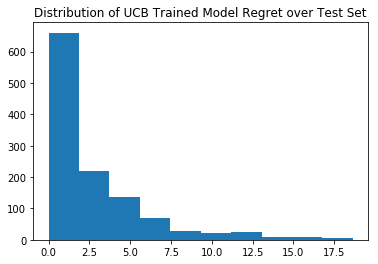

In [29]:
# regret histogram on test set 
plt.hist(regret)
plt.title("Distribution of UCB Trained Model Regret over Test Set", fontsize = 12)